In [1]:
import os
import sys
import numpy as np
import scipy.stats
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import scipy.cluster.hierarchy

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Arial')

In [3]:
nreads=['10k','20k','50k','100k','200k']
nclones=[10,25,100,250,1000,2500,10000,25000]
reps=[1,2]

In [4]:
nC={}
entropy={}
CC={}
FC={}
cpu_time={}
memory={}
for nc in nclones:
    for nr in nreads:
        for rep in reps:
            sfile='swibrid_runs/benchmark/dense/pipeline/mix_n{0}_s{1}_{2}/mix_n{0}_s{1}_{2}_cutoff_scanning.csv'.format(nc,rep,nr)
            if os.path.isfile(sfile):
                tmp=pd.read_csv(sfile, header=0,index_col=0)
                nC[(nc,nr,rep,'exact')]=tmp['nclusters']
                entropy[(nc,nr,rep,'exact')]=tmp['entropy']
            cfile='swibrid_runs/benchmark/dense/pipeline/mix_n{0}_s{1}_{2}/mix_n{0}_s{1}_{2}_clustering.csv'.format(nc,rep,nr)
            if os.path.isfile(cfile):
                tmp=pd.read_csv(cfile, header=0,index_col=0)
                CC[(nc,nr,rep,'exact')]=tmp['cluster']
                FC[(nc,nr,rep,'exact')]=tmp['filtered_cluster']
            bfile='swibrid_runs/benchmark/dense/benchmarks/mix_n{0}_s{1}_{2}_linkage.txt'.format(nc,rep,nr)
            if os.path.isfile(bfile):
                tmp=pd.read_csv(bfile, header=0, sep='\t').squeeze()
                cpu_time[(nc,nr,rep,'exact')]=tmp['s']
                memory[(nc,nr,rep,'exact')]=tmp['max_vms']
            sfile='swibrid_runs/benchmark/sparse/pipeline/mix_n{0}_s{1}_{2}/mix_n{0}_s{1}_{2}_cutoff_scanning.csv'.format(nc,rep,nr)
            if os.path.isfile(sfile):
                tmp=pd.read_csv(sfile, header=0,index_col=0)
                nC[(nc,nr,rep,'approx')]=tmp['nclusters']
                entropy[(nc,nr,rep,'approx')]=tmp['entropy']
            cfile='swibrid_runs/benchmark/sparse/pipeline/mix_n{0}_s{1}_{2}/mix_n{0}_s{1}_{2}_clustering.csv'.format(nc,rep,nr)
            if os.path.isfile(cfile):
                tmp=pd.read_csv(cfile, header=0,index_col=0)
                CC[(nc,nr,rep,'approx')]=tmp['cluster']
                FC[(nc,nr,rep,'approx')]=tmp['filtered_cluster']
            bfile='swibrid_runs/benchmark/sparse/benchmarks/mix_n{0}_s{1}_{2}_linkage.txt'.format(nc,rep,nr)
            if os.path.isfile(bfile):
                tmp=pd.read_csv(bfile, header=0, sep='\t').squeeze()
                cpu_time[(nc,nr,rep,'approx')]=tmp['s']
                memory[(nc,nr,rep,'approx')]=tmp['max_vms']

In [5]:
def f2(p, x):
    return p[0] * np.exp(-p[1] * x) + p[2] * np.exp(-p[3] * x)

def res2(p, x, y):
    return np.log(f2(p, x)) - np.log(y)

def fit_cutoff(cc, nn, method="fit"):
    import scipy
    import pandas as pd
    import numpy as np

    cc = np.asarray(cc)
    nn = np.asarray(nn)
    cmin = np.min(cc)
    cmax = np.max(cc)
    nmin = np.min(nn)
    nmax = np.max(nn)
    if method == "fit":

        #p0 = [nmax, 0, nmin, np.log(nmax / nmin) / (cmax - cmin)]
        p0 = [.75*(nmax - nmin), 10, .25*(nmax - nmin), 200]
        opt2 = scipy.optimize.least_squares(
            res2,
            1.0e-8 + np.array(p0),
            args=(cc, nn),
            method="dogbox",
            bounds=(0, np.inf),
        )
        if opt2.x[1] > opt2.x[3]:
            res = [opt2.x[2], opt2.x[3], opt2.x[0], opt2.x[1]]
        else:
            res = list(opt2.x)
        diff = pd.Series(np.abs(nn - res[0]), index=cc)
        cutoff = diff.sort_values().index[0]
        return res, cutoff
    elif method == "distance":
        diff = pd.Series(
            np.abs((cmax - cmin) * (nmax - nn) - (cmin - cc) * (nmin - nmax))
            / np.sqrt((cmax - cmin) ** 2 + (nmax - nmin) ** 2),
            index=cc,
        )
        cutoff = diff.sort_values().index[-1]
        return [], cutoff


In [6]:
fc = dict((k,fit_cutoff(v.index, v.values, method='fit')[0]) for k,v in nC.items())

/data/cephfs-1/home/users/obermayb_c/scratch/tmp/ipykernel_1193937/615750222.py:5: RuntimeWarning: divide by zero encountered in log
  return np.log(f2(p, x)) - np.log(y)


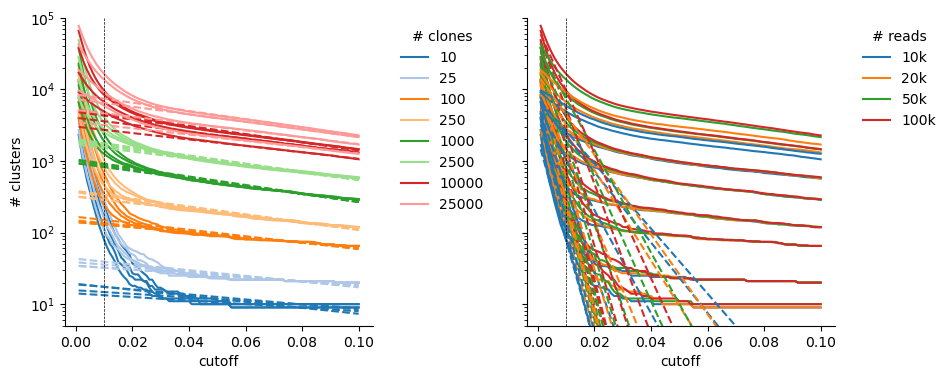

In [7]:
fig,axs=plt.subplots(1,2,figsize=(10,4),sharey=True)
fig.subplots_adjust(wspace=.5,hspace=.1, right=.85, left=.08)
for k in nC.keys():
    c=plt.cm.tab20(nclones.index(k[0]))
    if k[3]=='approx' or k[2] > 1:# or k[1]=='25k':
        continue
    axs[0].semilogy(nC[k].index, nC[k].values,'-',color=c,label=(k[0] if k[1]=='50k' else '_nolegend_'))
    axs[0].semilogy(nC[k].index, fc[k][0]*np.exp(-fc[k][1]*nC[k].index),'--',color=c)
    c=plt.cm.tab10(nreads.index(k[1]))
    axs[1].semilogy(nC[k].index, nC[k].values,'-',color=c,label=(k[1] if k[0]==10 else '_nolegend_'))
    axs[1].semilogy(nC[k].index, fc[k][2]*np.exp(-fc[k][3]*nC[k].index),'--',color=c)
axs[0].legend(loc=2,bbox_to_anchor=(1.05,1),frameon=False,title='# clones')
axs[1].legend(loc=2,bbox_to_anchor=(1.05,1),frameon=False,title='# reads')
axs[0].set_ylim([5,1.e5])
axs[1].set_ylim([5,1.e5])
axs[0].set_ylabel('# clusters')
axs[0].set_xlabel("cutoff")
axs[1].set_xlabel('cutoff')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[0].axvline(.01,color='k',linewidth=.5,ls='--')
axs[1].axvline(.01,color='k',linewidth=.5,ls='--')

fig.savefig('benchmark_cluster_trends.pdf')

In [8]:
opt_c = pd.Series(dict((k,fit_cutoff(v.index, v.values, method='distance')[1]) for k,v in nC.items())).unstack(level=3).reset_index().rename({'level_0':'nclones','level_1':'nreads','level_2':'replicate'},axis=1)

show the optimal cutoffs inferred from the "knee" in the cluster number plot

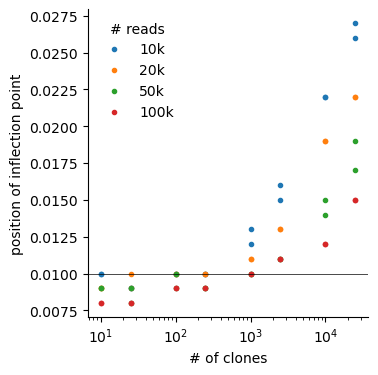

In [10]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
fig.subplots_adjust(left=.25,right=.95)

for nr in ['10k','20k','50k','100k']:
    use=(opt_c['nreads']==nr) 
    ax.semilogx(opt_c['nclones'][use],opt_c['exact'][use],'.',label=nr)
ax.axhline(.01,lw=.5,color='k')
ax.set_xlabel('# of clones')
ax.set_ylabel("position of inflection point")
ax.legend(loc=2,title='# reads',frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('benchmark_cluster_cutoffs.pdf')

In [11]:
def get_entropy(C):
    clusts,counts = np.unique(C, return_counts=True)
    o = np.argsort(counts)[::-1]
    entropy = np.array([np.nan]+[scipy.stats.entropy(counts[o[:i]])/np.log(i) for i in range(2,len(o))])
    return pd.DataFrame({'entropy': entropy, 'frac_reads': np.cumsum(counts[o])[1:]/len(C)},
                        index=np.arange(1,len(o)))

In [12]:
entropies=dict((k,get_entropy(CC[k])) for k in CC.keys())

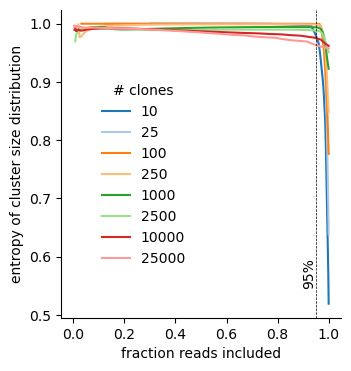

In [13]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
fig.subplots_adjust(left=.2)

for k,ee in entropies.items():
    c=plt.cm.tab20(nclones.index(k[0]))
    ls = '-' 
    if k[1] != '50k' or k[3]!='exact' or k[2] > 1:
        continue
    ax.plot(ee['frac_reads'], ee['entropy'],ls,color=c,label=(k[0] if k[1]=='50k' else '_nolegend_'))

ax.set_ylabel('entropy of cluster size distribution')
ax.set_xlabel("fraction reads included")
ax.axvline(.95,ls='dashed',lw=.5,color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(.95, .55, '95%', ha='right', rotation=90)
ax.legend(loc=2,bbox_to_anchor=(.1,.8),frameon=False, title='# clones')

fig.savefig('benchmark_cluster_filtering.pdf')

In [14]:
nclusters = dict((k, len(np.unique(FC[k]))-1) for k in FC.keys())

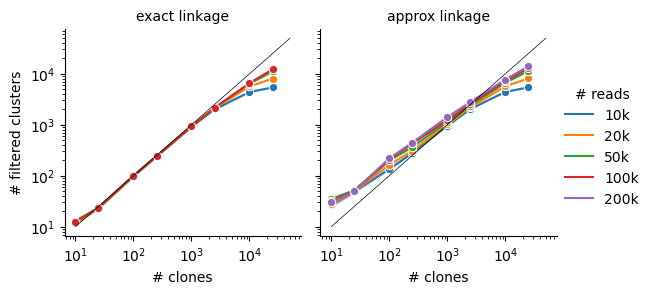

In [18]:
import seaborn as sns
df=pd.Series(nclusters).reset_index().rename({'level_0': '# clones',
                                              'level_1': '# reads',
                                              'level_2': 'replicate',
                                              'level_3': 'linkage',
                                              0: '# filtered clusters'},
                                             axis=1)

g=sns.relplot(data=df,x='# clones',y='# filtered clusters',hue='# reads',col='linkage',kind='line',marker='o', height=3,aspect=1)
g.set(xscale="log")
g.set(yscale="log")
xx=np.arange(10,5.e4)
for ax in g.axes.flat:
    ax.plot(xx,xx,'k-',lw=.5)
    
g.set_titles(row_template = '{row_name} linkage', col_template = '{col_name} linkage')
    
g.savefig('benchmark_cluster_linkage.pdf')

In [25]:
df=pd.concat([pd.Series(cpu_time),pd.Series(memory)],axis=1).reset_index().rename({'level_0': '# clones',
                                                                                   'level_1': '# reads',
                                                                                   'level_2': 'replicate',
                                                                                   'level_3': 'linkage',
                                                                                   0: 'time [s]',
                                                                                   1: 'memory [MB]'},axis=1)
df['# reads [k]']=df['# reads'].str[:-1].astype(int)
df['memory [Gb]']=df['memory [MB]']/1.e3
df['time [h]']=df['time [s]']/3600.

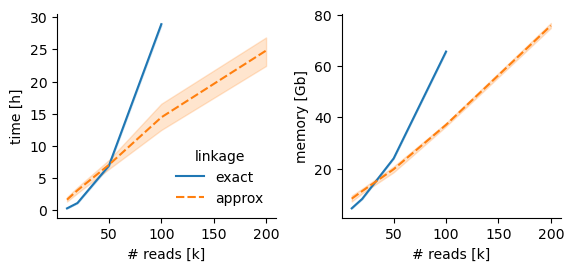

In [32]:
fig,axs=plt.subplots(1,2,figsize=(6.5,3))
fig.subplots_adjust(wspace=.3,bottom=.2)
g1=sns.lineplot(data=df,x='# reads [k]',y='time [h]',style='linkage',hue='linkage',ax=axs[0],legend='brief')
g2=sns.lineplot(data=df,x='# reads [k]',y='memory [Gb]',style='linkage',hue='linkage',ax=axs[1],legend=False)
#g1.set_xscale('log')
#g2.set_xscale('log')
axs[0].legend(frameon=False,loc=4,title='linkage')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

fig.savefig('benchmark_performance.pdf')

In [7]:
gap_sizes={}
gap_sizes['plasmid']=[np.load('swibrid_runs/human/pipeline/20200928_plasmid/20200928_plasmid_gaps.npz')['gap_size']]
gap_sizes['HD (minION)']=[np.load('swibrid_runs/human/pipeline/20230313_{0}/20230313_{0}_gaps.npz'.format(s))['gap_size'] for s in "HD19005,HD19006,HD19007,HD19015,HD19030,HD19031,HD19056,HD19059,HD19061,HD7036".split(',')]
gap_sizes['HD (pacBio)']=[np.load('swibrid_runs/human/pipeline/20230504_{0}/20230504_{0}_gaps.npz'.format(s))['gap_size'] for s in "HD19005,HD19006,HD19007,HD19015,HD19030,HD19031,HD19056,HD19059,HD19061,HD7036".split(',')]
#gap_sizes['simulation']=[np.load('swibrid_runs/benchmark/dense/pipeline/mix_n{0}_s{1}_{2}/mix_n{0}_s{1}_{2}_gaps.npz'.format(nc,rep,nr))['gap_size'] for nc in nclones for nr in nreads[:-1] for rep in reps]

In [8]:
num_reads={}
num_reads['plasmid']=[len(np.unique(np.load('swibrid_runs/human/pipeline/20200928_plasmid/20200928_plasmid_gaps.npz')['read_idx']))]
num_reads['HD (minION)']=[len(np.unique(np.load('swibrid_runs/human/pipeline/20230313_{0}/20230313_{0}_gaps.npz'.format(s))['read_idx'])) for s in "HD19005,HD19006,HD19007,HD19015,HD19030,HD19031,HD19056,HD19059,HD19061,HD7036".split(',')]
num_reads['HD (pacBio)']=[len(np.unique(np.load('swibrid_runs/human/pipeline/20230504_{0}/20230504_{0}_gaps.npz'.format(s))['read_idx'])) for s in "HD19005,HD19006,HD19007,HD19015,HD19030,HD19031,HD19056,HD19059,HD19061,HD7036".split(',')]
#num_reads['simulation']=[len(np.unique(np.load('swibrid_runs/benchmark/dense/pipeline/mix_n{0}_s{1}_{2}/mix_n{0}_s{1}_{2}_gaps.npz'.format(nc,rep,nr))['read_idx'])) for nc in nclones for nr in nreads[:-1] for rep in reps]

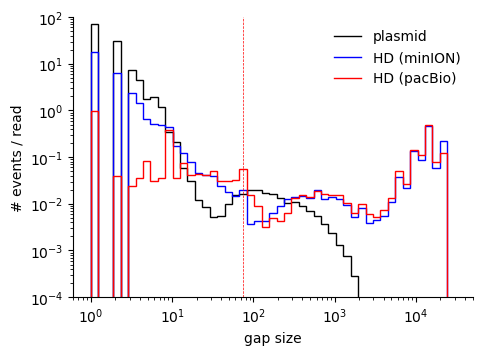

In [12]:
bins=np.geomspace(1, 3.0e4, 50)
hists=dict((k,np.histogram(np.concatenate(v),bins=bins)) for k,v in gap_sizes.items() if k!='simulation')
colors={'plasmid':'k','HD (minION)': 'b', 'HD (pacBio)': 'r', 'simulation': 'gray'}
fig,ax = plt.subplots(1,1, figsize=(5,3.5), squeeze=True)
fig.subplots_adjust(bottom=.15, right=.95, left=.15, top=.95)
for k, v in hists.items():
    ax.stairs(v[0]/np.sum(num_reads[k]), bins, lw=1, label=k, color=colors[k])

ax.axvline(75, lw=0.5, color="r", ls="dashed")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("# events / read")
ax.set_xlabel("gap size")
ax.set_ylim([1.e-4,1.e2])
ax.legend(loc=1, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('gap_size_histogram.pdf')